## Long short-term memory autoencoder

*Autoencoder* — архитектура нейронной сети, которая по входным данным получает выходные данные той же размерности. В зависимости от типа может иметь один или несколько скрытых слоев. Автоенкодеры имеют два модуля: кодировщик (encoder) и декодировщик (decoder). Кодировщик работает со здоровыми данными и изучает как устроены нормальные рабочие процессы системы, а затем сжимает данные в скрытое представление. Декодировщик пытается восстановить из этого представления выходные данные. Все что на выходе не соответсвует нормальному состоянию системы будет определено как аномалия. **Цель** — получить на выходном слое отклик, наиболее близкий к входному.

<img src="./img/ae_scheme.png" alt="Drawing" style="width: 600px; height: 350px"/>

В скрытых слоях используется реккурентный слой LSTM. В отличие от обычного реккурентного слоя, слой LSTM дополнительную имеет память и устроен более хитро, но благодаря этому может запоминать больший контекст входной последовательности.


<img src="./img/lstm_cell.png" alt="Drawing" style="width: 600px; height: 230px"/>

Помимо обычного входа и выхода, LSTM слой имеет прямую состояния, которая отвечает за запоминание и располагается вдоль всего слоя. На рисунке это верхняя горизонтальная прямая. Чтобы добавить, удалить или получить информацию из состояния существуют gates (гейты). 

1. Первый гейт отвечает за то, какую информацию нужно выбросить из состояния, он называется forget gate (гейт забывания). Решение принимается с помощью сигмоиды, область значений которой определена на интервале $[0, 1]$. Значение $0$ говорит о том, что вообще не нужно пропускать информацию дальше, значение $1$  пропускает информацию полностью.


2. Следующий шаг заключается в том, какую новую информацию необходимо сохранить в состояние, это input gate (входной гейт). Здесь есть три этапа. На первом через сигмоиду решается, какие значения в состоянии нужно обновить. На втором с помощью гиперболического тангенса (область значений которого интервал $[-1, 1]$), определяется "направление сохранения", т.е. на сколько нужно уменьшить или увеличить значение в состоянии. Третий этап это поэлементное умножение векторов (результирующий эффект обновления и направления) из предыдущих двух этапов и поэлементное сложение с вектором состояния, полученного из предыдущего гейта. 

После этого шага вектор состояния больше меняться не будет, в полученном виде он пойдет на следующую итерацию.

3. Осталось решить, что пойдет на выход, и за это отвечает третий гейт, который называется output gate (выходной гейт). На этом шаге сигмоида решает, что из вектора состояния, пропущенного через гиперболический тангенс, пойдет на выход. Можно провести аналогию со вторым шагом, только теперь тангенс является фильтром для вектора состояния, его контекст, накопленный в процессе обучения, помогает скорректировать выход на следующую итерацию.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE

### Seed fixation

In [3]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

### Process data

In [4]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


### Make predictor

In [5]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [6]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AE_Predictor(Predictor):
    def make_prediction(self, df):
        first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
        df = df.drop(['anomaly','changepoint'], axis=1)
        conf.train_size = first_anomaly_idx
        ss = StandardScaler()
        
        x_train = np.array(ss.fit_transform(df[:conf.train_size]))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_AE(optimizer=optimizer, loss='mae')
        model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)

        x_test = np.array(ss.transform(df))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))  
        health_r = r[:conf.train_size]
        
        # UCL = health_r.quantile(conf.Q)
        # Чтобы "выбросы" не испортили предсказания, убираем срабатывания на пересечении
        UCL = health_r[: len(health_r) - conf.TIME_STEPS + 1].quantile(conf.Q)
        
        anomalous_data = r > UCL
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS, len(x_test) - conf.TIME_STEPS + 1):
#             if np.all(anomalous_data[data_idx - conf.TIME_STEPS : data_idx]):
#                 anomalous_data_indices.append(data_idx - conf.TIME_STEPS)

            # Чуть более слабое условие для того чтобы по окну определить аномалию
            # Повышая порог можно увеличить мар и уменьшить фар
            if (anomalous_data[data_idx - conf.TIME_STEPS : data_idx]).astype(int).sum() >= conf.TIME_STEPS * 0.8:
                anomalous_data_indices.append(data_idx - conf.TIME_STEPS)
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

In [108]:
prediction = LSTM_AE_Predictor().make_prediction(df)

Epoch 1/10
53/53 [==============================] - 14s 137ms/step - loss: 0.6837
Epoch 2/10
53/53 [==============================] - 7s 126ms/step - loss: 0.6026
Epoch 3/10
53/53 [==============================] - 7s 125ms/step - loss: 0.5892
Epoch 4/10
53/53 [==============================] - 8s 147ms/step - loss: 0.5839
Epoch 5/10
53/53 [==============================] - 7s 132ms/step - loss: 0.5786
Epoch 6/10
53/53 [==============================] - 9s 172ms/step - loss: 0.5746
Epoch 7/10
53/53 [==============================] - 7s 137ms/step - loss: 0.5738
Epoch 8/10
53/53 [==============================] - 7s 132ms/step - loss: 0.5689
Epoch 9/10
53/53 [==============================] - 7s 130ms/step - loss: 0.5600
Epoch 10/10
53/53 [==============================] - 7s 130ms/step - loss: 0.5552


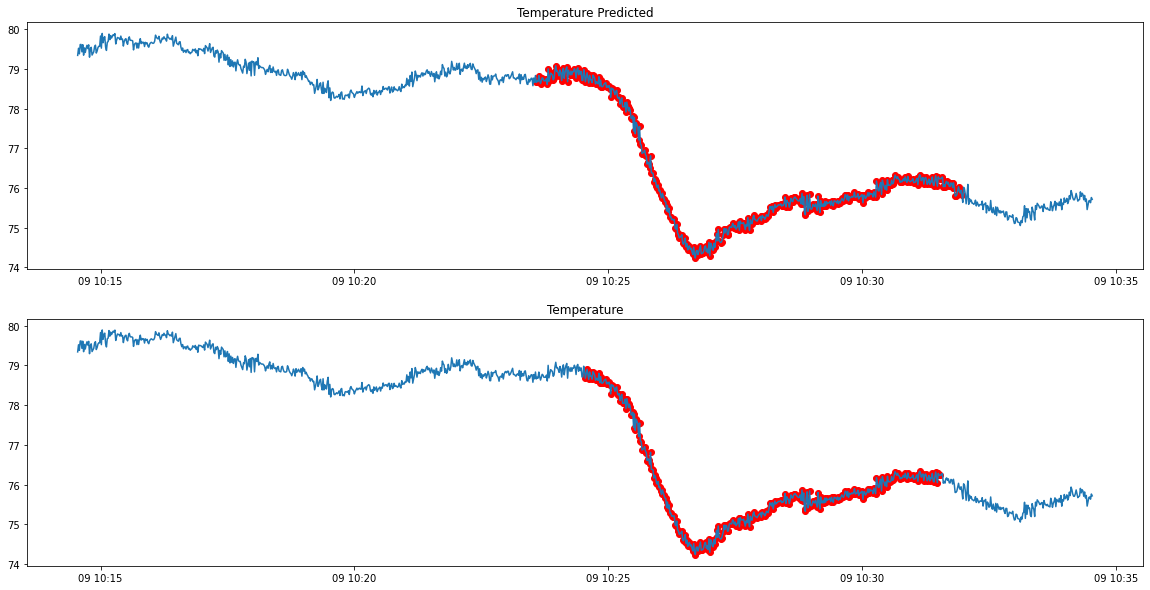

In [109]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [110]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.909297052154195
FAR = 0.10723860589812333
MAR = 0.0


### Применение метода ко всем датасетам

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 140ms/step - loss: 0.7775
Epoch 2/10
53/53 [==============================] - 7s 131ms/step - loss: 0.7116
Epoch 3/10
53/53 [==============================] - 7s 125ms/step - loss: 0.6584
Epoch 4/10
53/53 [==============================] - 7s 125ms/step - loss: 0.6278
Epoch 5/10
53/53 [==============================] - 11s 201ms/step - loss: 0.6149
Epoch 6/10
53/53 [==============================] - 9s 166ms/step - loss: 0.6028
Epoch 7/10
53/53 [==============================] - 9s 160ms/step - loss: 0.5954
Epoch 8/10
53/53 [==============================] - 7s 134ms/step - loss: 0.5899
Epoch 9/10
53/53 [==============================] - 7s 130ms/step - loss: 0.5818
Epoch 10/10
53/53 [==============================] - 7s 132ms/step - loss: 0.5773
Epoch 1/10
53/53 [==============================] - 12s 129ms/step - loss: 0.7338
Epoch 2/10
53/53 [==============================] - 8s 152ms/step - loss: 0.6605
Epoch 3/10
53/53 [======

IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 13s 145ms/step - loss: 0.7172
Epoch 2/10
52/52 [==============================] - 8s 144ms/step - loss: 0.6574
Epoch 3/10
52/52 [==============================] - 7s 141ms/step - loss: 0.6292
Epoch 4/10
52/52 [==============================] - 7s 134ms/step - loss: 0.6253
Epoch 5/10
52/52 [==============================] - 7s 136ms/step - loss: 0.6153
Epoch 6/10
52/52 [==============================] - 7s 125ms/step - loss: 0.6094
Epoch 7/10
52/52 [==============================] - 7s 135ms/step - loss: 0.6154
Epoch 8/10
52/52 [==============================] - 7s 140ms/step - loss: 0.6041
Epoch 9/10
52/52 [==============================] - 7s 128ms/step - loss: 0.6018
Epoch 10/10
52/52 [==============================] - 7s 134ms/step - loss: 0.5961
Epoch 1/10
52/52 [==============================] - 13s 145ms/step - loss: 182.7927
Epoch 2/10
52/52 [==============================] - 7s 126ms/step - loss: 59.3887
Epoch 3/10
52/52 [====

IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 126ms/step - loss: 0.7140
Epoch 2/10
53/53 [==============================] - 7s 128ms/step - loss: 0.6735
Epoch 3/10
53/53 [==============================] - 8s 142ms/step - loss: 0.6627
Epoch 4/10
53/53 [==============================] - 7s 133ms/step - loss: 0.6547
Epoch 5/10
53/53 [==============================] - 7s 133ms/step - loss: 0.6502
Epoch 6/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6464
Epoch 7/10
53/53 [==============================] - 7s 139ms/step - loss: 0.6426
Epoch 8/10
53/53 [==============================] - 7s 135ms/step - loss: 0.6364
Epoch 9/10
53/53 [==============================] - 7s 134ms/step - loss: 0.6296
Epoch 10/10
53/53 [==============================] - 7s 132ms/step - loss: 0.6263
F1 = 0.9241803278688525

FAR = 0.10013531799729364

MAR = 0.0

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 143ms/step - loss: 0.7281
Epoch 2/10
53/53 [==============================] - 6s 116ms/step - loss: 0.6704
Epoch 3/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6490
Epoch 4/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6377
Epoch 5/10
53/53 [==============================] - 8s 160ms/step - loss: 0.6275
Epoch 6/10
53/53 [==============================] - 12s 230ms/step - loss: 0.6219
Epoch 7/10
53/53 [==============================] - 6s 118ms/step - loss: 0.6126
Epoch 8/10
53/53 [==============================] - 6s 117ms/step - loss: 0.6054
Epoch 9/10
53/53 [==============================] - 6s 115ms/step - loss: 0.5973
Epoch 10/10
53/53 [==============================] - 6s 115ms/step - loss: 0.5906
F1 = 0.9103291713961408

FAR = 0.1063257065948856

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 142ms/step - loss: 0.7331
Epoch 2/10
53/53 [==============================] - 7s 129ms/step - loss: 1.1555
Epoch 3/10
53/53 [==============================] - 7s 141ms/step - loss: 0.6873
Epoch 4/10
53/53 [==============================] - 7s 133ms/step - loss: 0.6673
Epoch 5/10
53/53 [==============================] - 7s 140ms/step - loss: 0.6614
Epoch 6/10
53/53 [==============================] - 7s 140ms/step - loss: 0.6551
Epoch 7/10
53/53 [==============================] - 7s 140ms/step - loss: 0.6490
Epoch 8/10
53/53 [==============================] - 8s 143ms/step - loss: 0.6437
Epoch 9/10
53/53 [==============================] - 8s 143ms/step - loss: 0.6391
Epoch 10/10
53/53 [==============================] - 8s 149ms/step - loss: 0.6338
F1 = 0.9070796460176991

FAR = 0.11275167785234899

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 12s 138ms/step - loss: 0.7859
Epoch 2/10
52/52 [==============================] - 7s 140ms/step - loss: 0.6869
Epoch 3/10
52/52 [==============================] - 7s 142ms/step - loss: 0.6488
Epoch 4/10
52/52 [==============================] - 7s 135ms/step - loss: 0.6305
Epoch 5/10
52/52 [==============================] - 7s 137ms/step - loss: 0.6176
Epoch 6/10
52/52 [==============================] - 7s 134ms/step - loss: 0.6122
Epoch 7/10
52/52 [==============================] - 7s 129ms/step - loss: 0.6083
Epoch 8/10
52/52 [==============================] - 7s 139ms/step - loss: 0.6032
Epoch 9/10
52/52 [==============================] - 7s 138ms/step - loss: 0.6003
Epoch 10/10
52/52 [==============================] - 8s 145ms/step - loss: 0.5953
F1 = 0.8995633187772926

FAR = 0.09336941813261164

MAR = 0.0

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
45/45 [==============================] - 11s 130ms/step - loss: 0.7041
Epoch 2/10
45/45 [==============================] - 6s 130ms/step - loss: 0.5806
Epoch 3/10
45/45 [==============================] - 6s 130ms/step - loss: 0.5576
Epoch 4/10
45/45 [==============================] - 6s 135ms/step - loss: 0.5410
Epoch 5/10
45/45 [==============================] - 6s 140ms/step - loss: 0.5245
Epoch 6/10
45/45 [==============================] - 6s 137ms/step - loss: 0.5132
Epoch 7/10
45/45 [==============================] - 6s 133ms/step - loss: 0.5099
Epoch 8/10
45/45 [==============================] - 6s 143ms/step - loss: 0.4968
Epoch 9/10
45/45 [==============================] - 6s 133ms/step - loss: 0.4936
Epoch 10/10
45/45 [==============================] - 6s 131ms/step - loss: 0.4882
F1 = 0.6902654867256637

FAR = 0.04711246200607903

MAR = 0.41132075471698115

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 12s 133ms/step - loss: 0.7603
Epoch 2/10
52/52 [==============================] - 7s 130ms/step - loss: 0.6753
Epoch 3/10
52/52 [==============================] - 7s 137ms/step - loss: 0.6565
Epoch 4/10
52/52 [==============================] - 7s 136ms/step - loss: 0.6466
Epoch 5/10
52/52 [==============================] - 7s 131ms/step - loss: 0.6371
Epoch 6/10
52/52 [==============================] - 7s 127ms/step - loss: 0.6330
Epoch 7/10
52/52 [==============================] - 7s 141ms/step - loss: 0.6279
Epoch 8/10
52/52 [==============================] - 7s 133ms/step - loss: 0.6241
Epoch 9/10
52/52 [==============================] - 7s 134ms/step - loss: 0.6192
Epoch 10/10
52/52 [==============================] - 7s 128ms/step - loss: 0.6148
F1 = 0.9149425287356322

FAR = 0.10013531799729364

MAR = 0.0

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
51/51 [==============================] - 11s 124ms/step - loss: 0.7332
Epoch 2/10
51/51 [==============================] - 6s 125ms/step - loss: 0.6581
Epoch 3/10
51/51 [==============================] - 6s 124ms/step - loss: 0.6275
Epoch 4/10
51/51 [==============================] - 7s 128ms/step - loss: 0.6188
Epoch 5/10
51/51 [==============================] - 7s 129ms/step - loss: 0.6134
Epoch 6/10
51/51 [==============================] - 6s 127ms/step - loss: 0.6098
Epoch 7/10
51/51 [==============================] - 6s 123ms/step - loss: 0.6068
Epoch 8/10
51/51 [==============================] - 6s 124ms/step - loss: 0.6016
Epoch 9/10
51/51 [==============================] - 7s 131ms/step - loss: 0.5974
Epoch 10/10
51/51 [==============================] - 7s 134ms/step - loss: 0.5911
F1 = 0.29304029304029305

FAR = 0.0807899461400359

MAR = 0.7872340425531915

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 15s 147ms/step - loss: 0.7640
Epoch 2/10
53/53 [==============================] - 8s 143ms/step - loss: 0.7052
Epoch 3/10
53/53 [==============================] - 7s 129ms/step - loss: 0.6766
Epoch 4/10
53/53 [==============================] - 8s 151ms/step - loss: 0.6642
Epoch 5/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6572
Epoch 6/10
53/53 [==============================] - 7s 128ms/step - loss: 0.6505
Epoch 7/10
53/53 [==============================] - 9s 168ms/step - loss: 0.6452
Epoch 8/10
53/53 [==============================] - 8s 146ms/step - loss: 0.6411
Epoch 9/10
53/53 [==============================] - 7s 140ms/step - loss: 0.6297
Epoch 10/10
53/53 [==============================] - 7s 124ms/step - loss: 0.6248
F1 = 0.895483870967742

FAR = 0.10901749663526245

MAR = 0.0

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 125ms/step - loss: 0.7640
Epoch 2/10
53/53 [==============================] - 7s 126ms/step - loss: 0.7024
Epoch 3/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6749
Epoch 4/10
53/53 [==============================] - 7s 124ms/step - loss: 0.6610
Epoch 5/10
53/53 [==============================] - 7s 137ms/step - loss: 0.6511
Epoch 6/10
53/53 [==============================] - 7s 134ms/step - loss: 0.6436
Epoch 7/10
53/53 [==============================] - 7s 122ms/step - loss: 0.6375
Epoch 8/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6312
Epoch 9/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6243
Epoch 10/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6231
F1 = 0.9421221864951769

FAR = 0.09716599190283401

MAR = 0.0

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 123ms/step - loss: 0.8056
Epoch 2/10
53/53 [==============================] - 7s 123ms/step - loss: 0.7557
Epoch 3/10
53/53 [==============================] - 7s 123ms/step - loss: 0.7287
Epoch 4/10
53/53 [==============================] - 7s 123ms/step - loss: 0.7220
Epoch 5/10
53/53 [==============================] - 7s 127ms/step - loss: 0.7130
Epoch 6/10
53/53 [==============================] - 7s 123ms/step - loss: 0.7026
Epoch 7/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6909
Epoch 8/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6819
Epoch 9/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6802
Epoch 10/10
53/53 [==============================] - 7s 134ms/step - loss: 0.6731
F1 = 0.6726943942133815

FAR = 0.1077943615257048

MAR = 0.3841059602649007

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
75/75 [==============================] - 18s 161ms/step - loss: 0.7359
Epoch 2/10
75/75 [==============================] - 10s 139ms/step - loss: 0.6469
Epoch 3/10
75/75 [==============================] - 11s 146ms/step - loss: 0.6298
Epoch 4/10
75/75 [==============================] - 10s 132ms/step - loss: 0.6198
Epoch 5/10
75/75 [==============================] - 12s 158ms/step - loss: 0.6139
Epoch 6/10
75/75 [==============================] - 9s 123ms/step - loss: 0.6093
Epoch 7/10
75/75 [==============================] - 10s 128ms/step - loss: 0.6052
Epoch 8/10
75/75 [==============================] - 10s 140ms/step - loss: 0.5993
Epoch 9/10
75/75 [==============================] - 10s 128ms/step - loss: 0.5988
Epoch 10/10
75/75 [==============================] - 9s 123ms/step - loss: 0.5942
F1 = 0.7169811320754716

FAR = 0.059045226130653265

MAR = 0.37468354430379747

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 13s 137ms/step - loss: 0.7423
Epoch 2/10
53/53 [==============================] - 8s 146ms/step - loss: 0.7088
Epoch 3/10
53/53 [==============================] - 7s 137ms/step - loss: 0.6889
Epoch 4/10
53/53 [==============================] - 7s 122ms/step - loss: 0.6738
Epoch 5/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6630
Epoch 6/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6602
Epoch 7/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6427
Epoch 8/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6304
Epoch 9/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6259
Epoch 10/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6215
F1 = 0.9064261555806088

FAR = 0.11140939597315436

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 127ms/step - loss: 0.7597
Epoch 2/10
53/53 [==============================] - 7s 123ms/step - loss: 0.7116
Epoch 3/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6915
Epoch 4/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6798
Epoch 5/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6669
Epoch 6/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6591
Epoch 7/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6527
Epoch 8/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6524
Epoch 9/10
53/53 [==============================] - 7s 122ms/step - loss: 0.6468
Epoch 10/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6392
F1 = 0.9005586592178771

FAR = 0.1196236559139785

MAR = 0.0

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
6/6 [==============================] - 5s 124ms/step - loss: 0.7926
Epoch 2/10
6/6 [==============================] - 1s 123ms/step - loss: 0.7856
Epoch 3/10
6/6 [==============================] - 1s 121ms/step - loss: 0.7625
Epoch 4/10
6/6 [==============================] - 1s 121ms/step - loss: 0.7474
Epoch 5/10
6/6 [==============================] - 1s 123ms/step - loss: 0.7410
Epoch 6/10
6/6 [==============================] - 1s 121ms/step - loss: 0.7395
Epoch 7/10
6/6 [==============================] - 1s 121ms/step - loss: 0.7351
Epoch 8/10
6/6 [==============================] - 1s 122ms/step - loss: 0.7317
Epoch 9/10
6/6 [==============================] - 1s 123ms/step - loss: 0.7283
Epoch 10/10
6/6 [==============================] - 1s 121ms/step - loss: 0.7239
F1 = 0.7901234567901234

FAR = 0.5151515151515151

MAR = 0.0

CPU times: user 1h 55min 22s, sys: 6min 26s, total: 2h 1min 48s
Wall time: 43min 28s


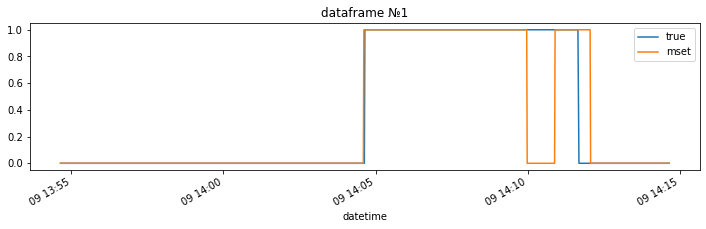

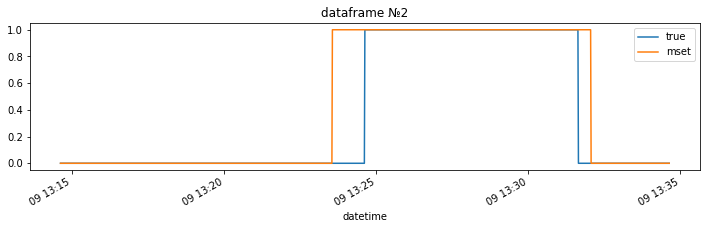

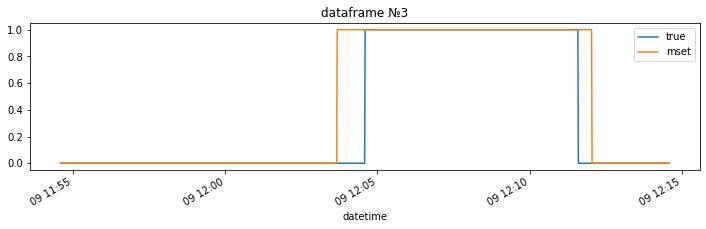

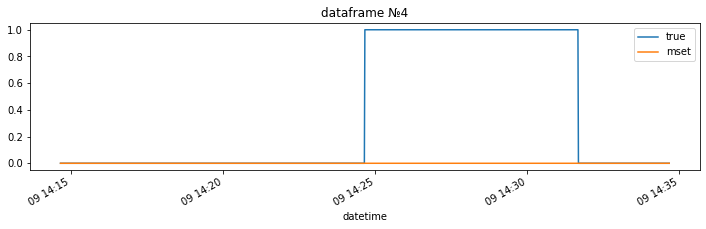

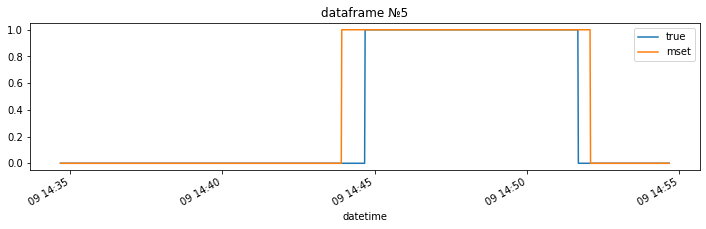

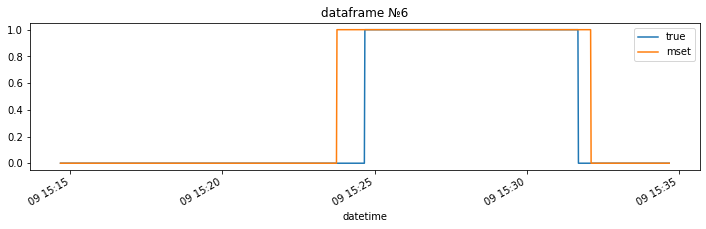

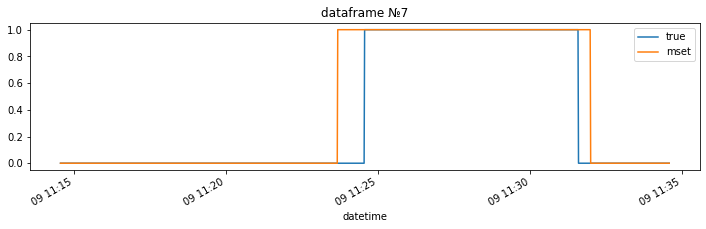

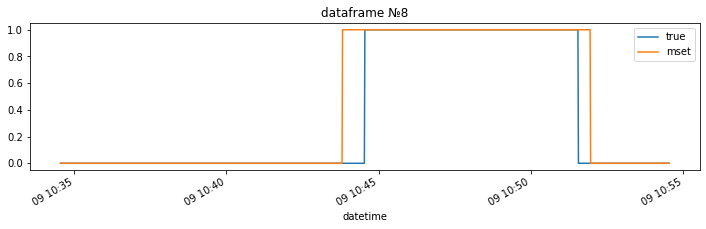

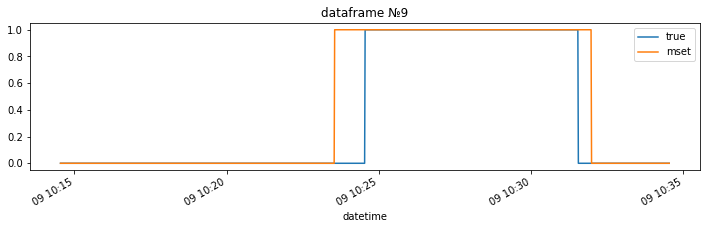

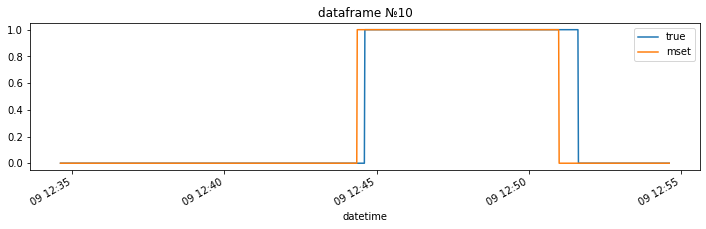

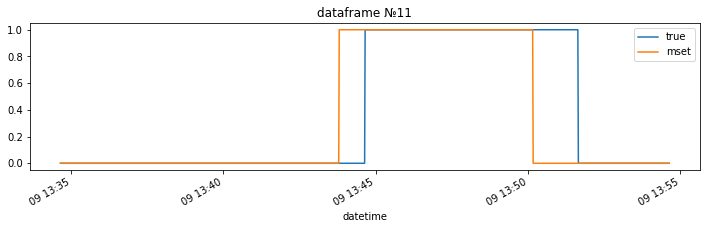

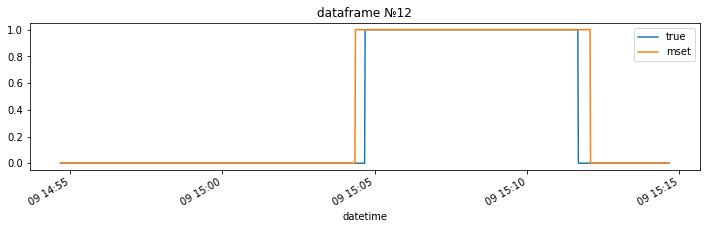

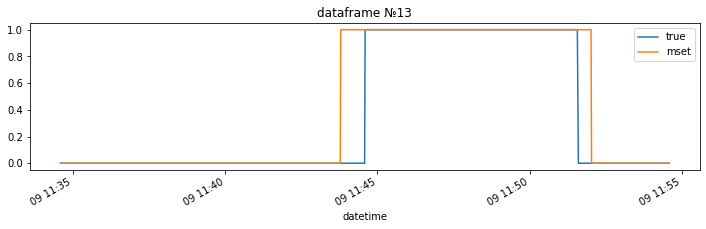

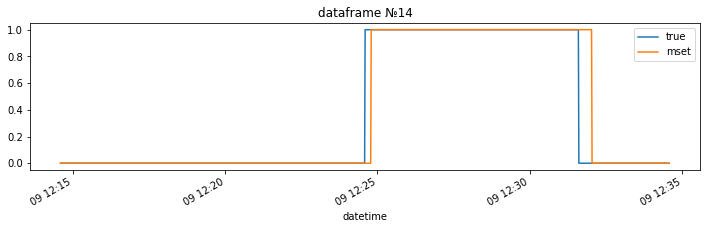

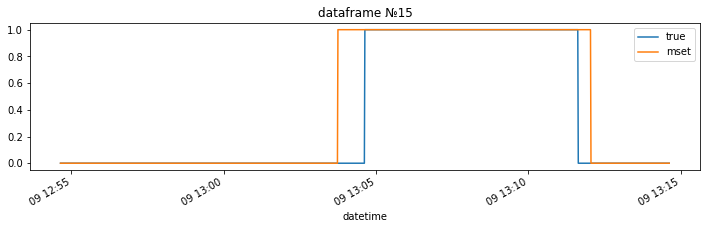

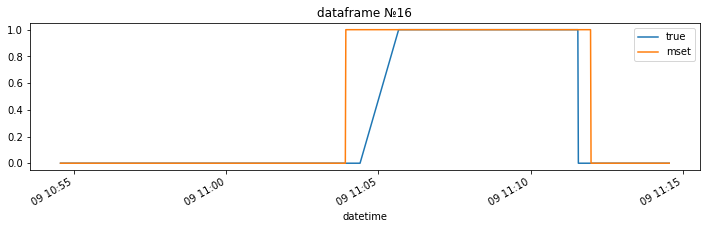

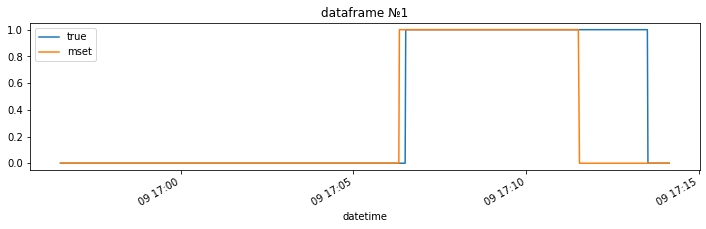

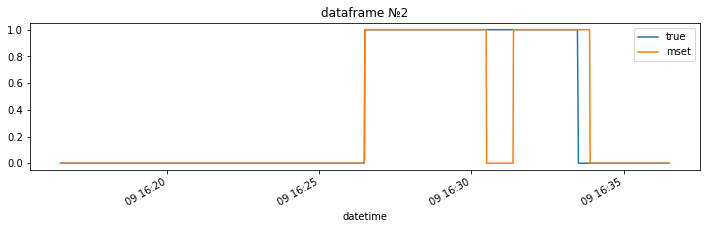

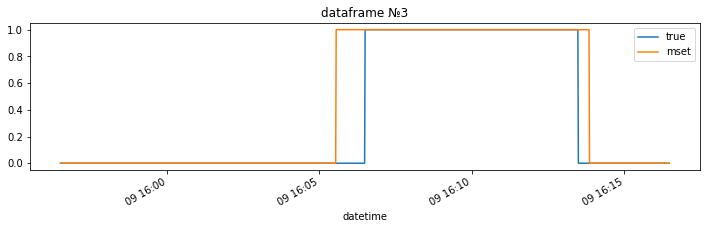

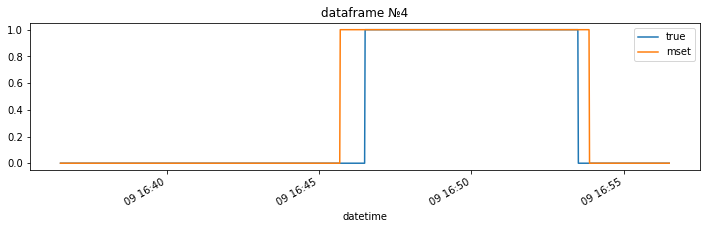

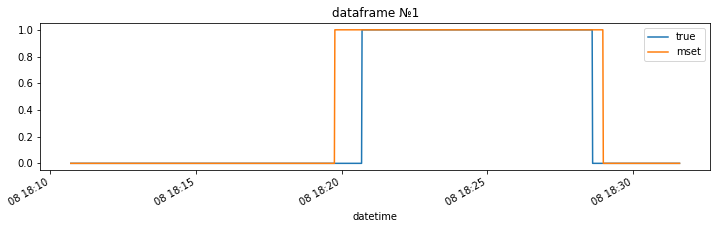

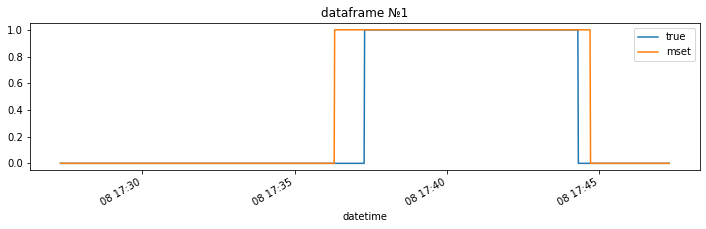

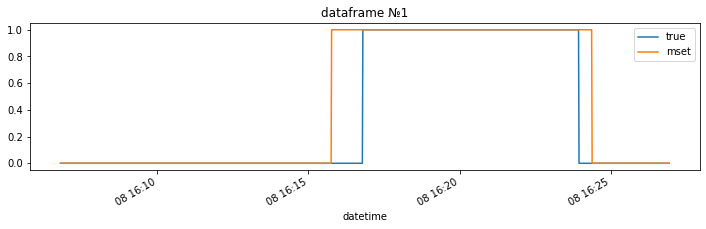

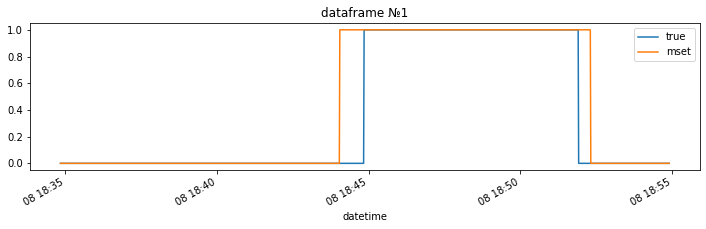

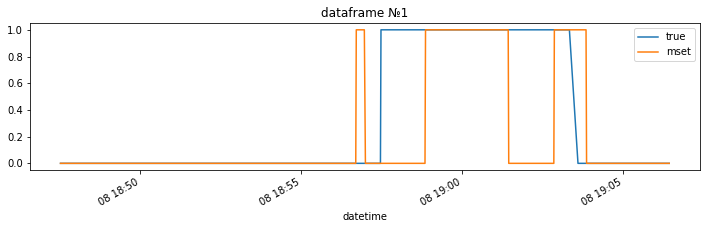

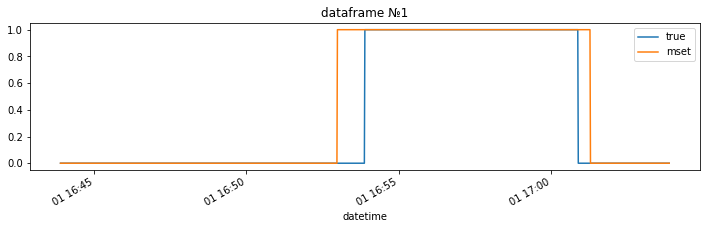

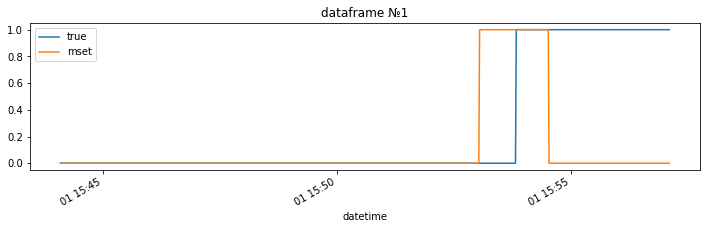

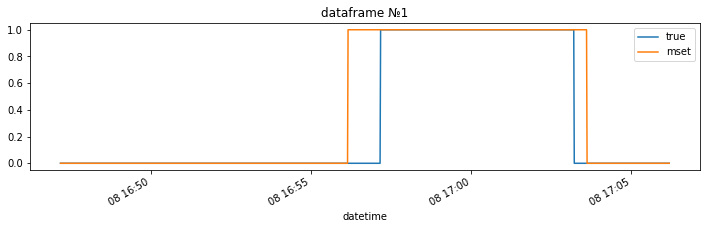

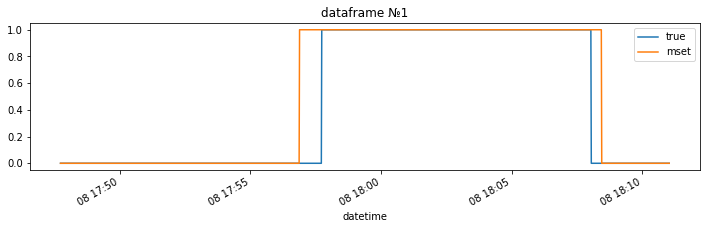

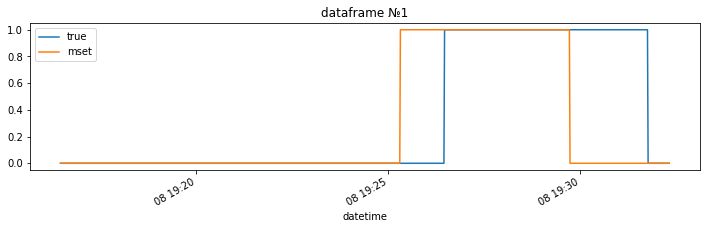

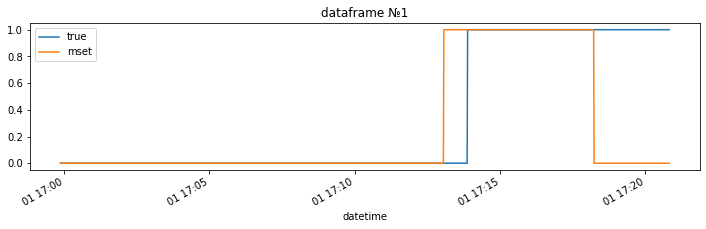

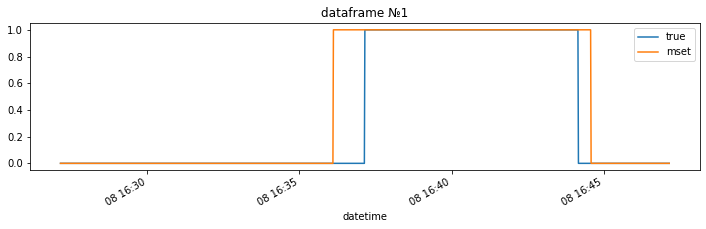

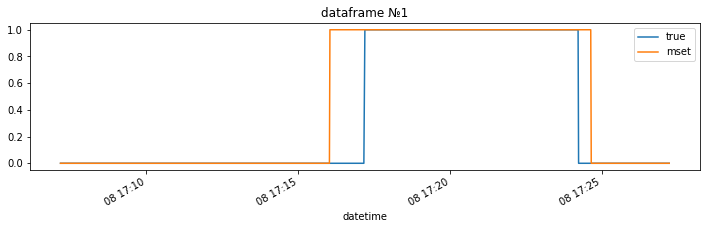

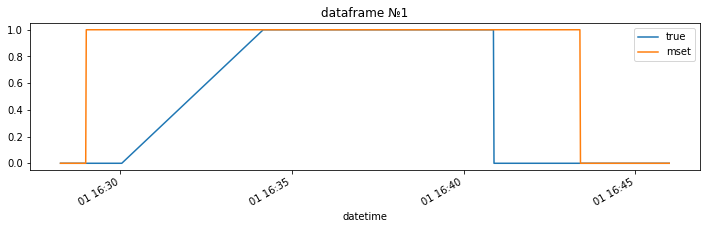

In [9]:
%%time
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = LSTM_AE_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [60]:
from utils.metrics import f1_score, far, mar

pred_outlier = pd.concat([pd.concat(p.all_predictions[i]) 
                          for i in range(len(p.all_predictions))])

list_of_all_df = []
for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            list_of_all_df.append(pd.concat([df.anomaly for df in [df, ]]))
    else:
        list_of_all_df.append(pd.concat([df.anomaly for df in list_of_df]))

true_outlier = pd.concat(list_of_all_df)

f1 = f1_score(true_outlier, pred_outlier)
far_score = far(true_outlier, pred_outlier)
mar_score = mar(true_outlier, pred_outlier)

metrics["all"] = (f1, far_score, mar_score)

In [61]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.89 | 0.89 | 0.92 | 0.91 | 0.91 | 0.9 | 0.69 | 0.91 | 0.29 | 0.9 | 0.94 | 0.67 | 0.72 | 0.91 | 0.9 | 0.79 | 0.87
FAR |0.07 | 0.06 | 0.1 | 0.11 | 0.11 | 0.09 | 0.05 | 0.1 | 0.08 | 0.11 | 0.1 | 0.11 | 0.06 | 0.11 | 0.12 | 0.52 | 0.09
MAR |0.09 | 0.11 | 0.0 | 0.0 | 0.0 | 0.0 | 0.41 | 0.0 | 0.79 | 0.0 | 0.0 | 0.38 | 0.37 | 0.0 | 0.0 | 0.0 | 0.1